In [1]:
import csv
import json
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import random
from collections import deque
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import load_model

In [2]:
#NEW DATA TEST
caiso=pd.read_csv("/Users/john_schafer/Downloads/CE291/CAISO_zone_1_.csv")

#Transform Data to our format
caiso['time'] = pd.to_datetime(caiso['time'])
caiso.set_index('time', inplace=True)

# Function to reshape the data
def reshape_data(df, column):
    # Resample data to daily frequency, and apply list to convert each day's data into a list
    daily_data = df[column].resample('D').apply(list)
    # Convert lists to a DataFrame, which inherently transposes the list to columns
    return pd.DataFrame(daily_data.tolist(), index=daily_data.index)

# Creating each DataFrame
demand_df = reshape_data(caiso, 'load_power')
solar_df = reshape_data(caiso, 'solar_power')
wind_df = reshape_data(caiso, 'wind_power')

def rename_columns(df):
    num_minutes = df.shape[1]
    time_labels = [str(pd.Timedelta(minutes=i)) for i in range(num_minutes)]
    df.columns = time_labels
    return df

demand_df = rename_columns(demand_df)
solar_df = rename_columns(solar_df)
wind_df = rename_columns(wind_df)


#Scaling 
# if power is normalized to 1, PEV dynamics in environment are run in kw
#max power of single Ev = 11 kw 
#max power of representative small microgrid of 5,000 people ~ 3.5 megawatts=3,500 kw
#multiply vby 3500 to get representative 
demand_caiso = np.array(demand_df)
solar_caiso = np.array(solar_df)*3 
wind_caiso = np.array(wind_df)*4 
net_caiso=demand_caiso-solar_caiso-wind_caiso

average_demand_per_minute = np.nanmean(demand_caiso, axis=0)
average_solar_per_minute = np.nanmean(solar_caiso, axis=0)
average_wind_per_minute = np.nanmean(wind_caiso, axis=0)

average_net_per_minute=average_demand_per_minute-average_solar_per_minute-average_wind_per_minute

#Sample only every ten minutes
average_demand_10min= average_demand_per_minute[::10]
average_solar_10min= average_solar_per_minute[::10]
average_wind_10min= average_wind_per_minute[::10]

average_net_10min=average_demand_10min-average_solar_10min-average_wind_10min

average_demand_10min= average_demand_10min.reshape(144,1).T
average_solar_10min=average_solar_10min.reshape(144,1).T
average_wind_10min=average_wind_10min.reshape(144,1).T

In [3]:
from DQL_percent_action import DQNAgent
from env_percent_action import GridEnvironment
import time
from tensorflow.keras.models import load_model

In [4]:

timestep_length=(10/60) #in hours
N=1000
sequence_length=12 #In timesteps aka 120 minutes
state_deque = deque(maxlen=sequence_length)

day_index=0
model_500 = tf.keras.models.load_model('/Users/john_schafer/Downloads/CE291/CE291-V2G/model_perc_action_500.h5')
# Initialize DQN agent
agent = DQNAgent(state_size=3+1+N, action_size=201, sequence_length=sequence_length, model=model_500)

episode_durations = []
agent.epsilon=.08

for episode in range(2):  # Loop over 3 episodes of same "average" day
    # Initialize environment for the current day
    start_time = time.time()
    env = GridEnvironment(N, average_demand_10min, average_solar_10min, average_wind_10min, day_index, timestep_length)
    
    total_reward = 0
    T = 144  # Assume T timesteps in a day

    demand_profile = np.zeros(T)
    solar_profile = np.zeros(T)
    wind_profile = np.zeros(T)
    PEV_profile = np.zeros(T)

    for timestep in range(1, T+1):  # Loop through each timestep in the day
        normalized_timestep = np.array([timestep / T])   # T is the total number of timesteps in a day

        current_demand, current_solar, current_wind, current_SoC = env.get_state()
        current_P_EV= env.P_EV

        current_state=np.concatenate([np.array([current_demand, current_solar, current_wind]), normalized_timestep, current_SoC])

        state_deque.append(current_state)
        state_history = np.array(state_deque)

        if len(state_deque) < sequence_length:
            continue  # Wait until deque is full before starting training
        
        action = agent.act(state_history)  # Decide action based on current state

        # Execute action in the environment and observe the next state, reward, and done flag
        reward, done, next_demand, next_solar, next_wind, next_P_EV, next_SoC = env.step(action)

        # Update profiles for plotting
        demand_profile[timestep - 1] = next_demand
        solar_profile[timestep - 1] = next_solar
        wind_profile[timestep - 1] = next_wind
        PEV_profile[timestep - 1] = np.sum(next_P_EV)
        
        normalized_next_timestep = np.array([(timestep+1) / T])
        # Construct the new state from the separated components
        next_state = np.concatenate([np.array([next_demand, next_solar, next_wind]), normalized_next_timestep, next_SoC])

        # Directly learn from this transition without using replay
        agent.learn(state_history, action, reward, next_state, done)

        # Update state and total_reward
        #state = next_state why did I have this?
        total_reward += reward

        if done:
            # Handle episode completion, if applicable
            break
    agent.epsilon=max(agent.epsilon_min, agent.epsilon * agent.epsilon_decay) 

    print(f"Total reward for episode {episode}: {total_reward}")
    episode_durations.append(time.time() - start_time)
#agent.model.save('model_perc_action_500.h5')
print("Individual episode durations:", episode_durations)

2024-04-21 23:06:15.290839: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Total reward for episode 0: -94.56491711798887
Total reward for episode 1: -111.78043374235705
Individual episode durations: [12.849261999130249, 12.989197015762329]


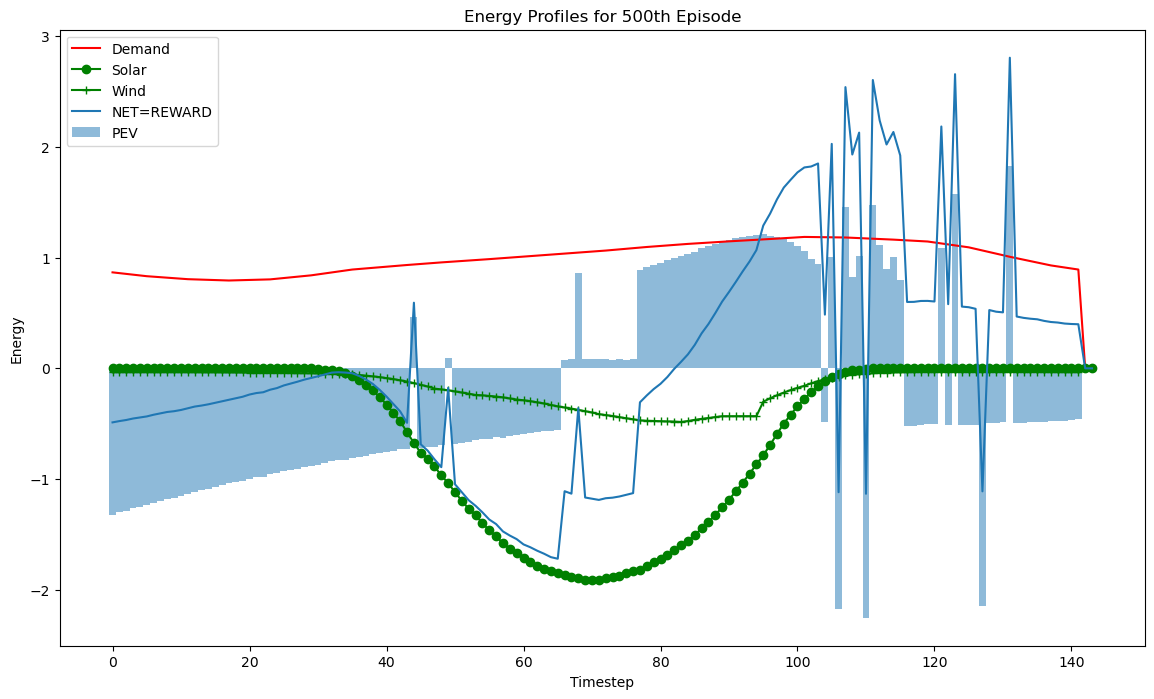

In [6]:
plt.figure(figsize=(14, 8))
plt.plot(demand_profile, label='Demand', color="red")
plt.plot(-1*solar_profile, label='Solar', color='green', marker='o')
plt.plot(-1*wind_profile, label='Wind', color='green', marker='+')

plt.plot(demand_profile+PEV_profile -solar_profile- wind_profile, label='NET=REWARD')

# Plot the PEV_profile as a bar graph
timesteps = np.arange(len(PEV_profile))  
plt.bar(timesteps, PEV_profile, width=1.0, label='PEV', alpha=0.5)  



plt.legend()
plt.title('Energy Profiles for 500th Episode')
plt.xlabel('Timestep')
plt.ylabel('Energy')
plt.savefig('500_episodes_perc_action.png')
plt.show()